In [1]:
from scipy.integrate import *
from pandas import *
from numpy import *
from pylab import *
from scipy import integrate
import math
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
#parameter values
phi1 = 0.001 #interaction strength for p1
phi2 = 0.001 #interaction strength for p2
eps1 = 0.1 #transfer efficiency for p1
eps2 = 0.1 #transfer efficiency for p2
delta_c = 0.1 #consumer mortality
k_w = 0.02 #light attenuation by just water
k_p = 0.001 #attenuation due to producers
delta1 = 0.12 #death rate of producer 1
delta2 = 0.12 #death rate of producer 2
mu1 = 1 #resource affinity parameter for p1
mu2 = 1 #resource affinity parameter for p2
alpha_n = 1 #saturation of nutrients
alpha_i = 1 #saturation of light
S_R = 0.4 #supply rate

In [3]:
# time change (discrete time)
T = 365.0 #days
delt = 1.0/240.0
t = np.linspace(0, T, int(T/delt)) #time array
#print(t)

# array  to store  the  solution if you were using Euler's method
N = np.zeros(len(t))
P1 = np.zeros(len(t))
P2 = np.zeros(len(t))
C = np.zeros(len(t))
N[0] = 500
P1[0] = 100
P2[0] = 100
C[0] = 100

#create an array with your starting values for odeint
y0 = np.array([N[0], P1[0],P2[0],C[0]]) 
print(y0)

[500. 100. 100. 100.]


In [4]:
zetas = np.linspace(0,100,50) #depth array
print(len(zetas))

50


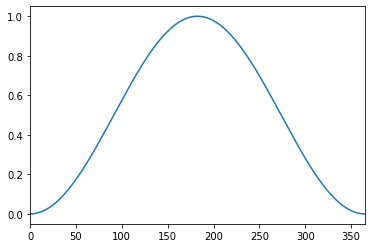

In [5]:
#initial irradiance equation (seasonality)
I_naughts = (np.sin(((t)/365*2*math.pi-math.pi/2))+1)/2
plt.plot(t,I_naughts)

#only plot 1 year
plt.xlim([0,365])
plt.show()



In [6]:
# creating irradiance array
Is = [] #empty list
for I_naught in I_naughts:
    # accounting for initial values of phytoplankton
    I = I_naught * np.exp((-k_w*zetas)-(k_p*(P1[0]+P2[0])))
    Is.append(I)
light_att = np.array(Is) # make list into an array
lights = light_att.T #transpose

print(zetas.shape)
print(lights.shape)

(50,)
(50, 8760000)


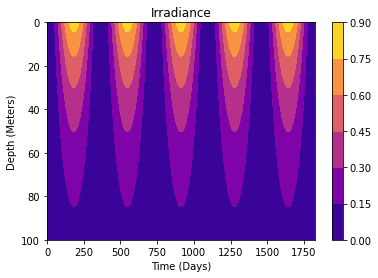

In [7]:
#contour plot of seasonal irradiance
plt.contourf(t,zetas,lights,cmap = 'plasma')
plt.gca().invert_yaxis()
plt.xlim([0,1825])
plt.xlabel('Time (Days)', color = 'k')
plt.ylabel('Depth (Meters)', color = 'k')
plt.title('Irradiance')
plt.colorbar()
plt.show()


In [8]:
#spline of initial light seasonality
I_naughts_interp = InterpolatedUnivariateSpline(t, I_naughts)

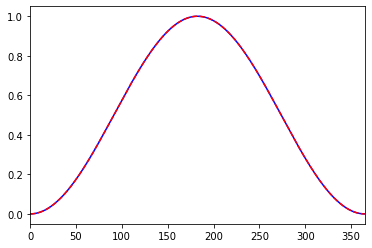

In [9]:
#plotting spline and i_naught to make sure that line up
plt.plot(t, I_naughts, 'b')
plt.plot(t, I_naughts_interp(t), '--r')
plt.xlim([0,365]) # run for just 1 year
plt.show()

In [10]:
#light function

def irradiance_function(zetas, P1,P2, i, j, dep_size):
    I = I_naughts[i] * np.exp(-(k_w*zetas[j]+np.sum(k_p*(P1[:j]+P2[:j])*dep_size)))
    return I

In [11]:
j = 0
i = 25
dep_size = 2 #depth (meters) in steps

light_list = []
for j in range(len(zetas)):
    loop = irradiance_function(zetas, P1, P2, i, j, dep_size)
    light_list.append(loop)
    
light_array = np.array(light_list)

In [12]:
#ODE model function
def npc_model(y, t, zeta, delta1, delta2, delta_c, phi1, phi2, eps1, eps2, mu1, mu2, S_R):
    N, P1, P2, C = y[0], y[1], y[2], y[3]
    I_naught = I_naughts_interp(t)
    if I_naught < 0:
        I_naught = 0.
    I = I_naughts[i] * np.exp(-(k_w*zetas[j]+np.sum(k_p*(P1[:j]+P2[:j])*dep_size)))
    mu1_growth = np.minimum((N/(N+(mu1/alpha_n))), (I/(I+(mu1/alpha_i))))
    mu2_growth = np.minimum((N/(N+(mu2/alpha_n))), (I/(I+(mu2/alpha_i))))
    dNdt = S_R - mu1_growth*mu1*P1 - mu2_growth*mu2*P2 + delta1*P1 + delta2*P2
    dP1dt = mu1_growth*mu1*P1 - delta1*P1 - phi1*P1*C
    dP2dt = mu2_growth*mu2*P2 - delta2*P2 - phi2*P2*C
    dCdt = eps1*phi1*P1*C + eps2*phi2*P2*C - delta_c*C
    return np.array([dNdt, dP1dt, dP2dt, dCdt])

In [13]:
# run ODE integration
tim = []
for zeta in zetas:
    integ_sivz = odeint(npc_model, y0, t, args=(zeta, delta1, delta2, delta_c, phi1, phi2, eps1, eps2, mu1, mu2, S_R))
    tim.append(integ_sivz)
sols = array(tim)
print(sols)


IndexError: invalid index to scalar variable.

KeyboardInterrupt: 

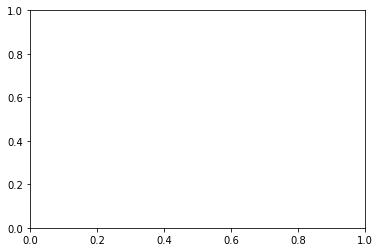

In [107]:
plt.figure()

#plot producer 1
plt.plot(t,sols[:,:,1], '--', color = 'orange')

#plot producer 2
plt.plot(t,sols[:,:,2], 'blue')

#plot consumer
plt.plot(t, sols[:,:,3], color = 'grey', linestyle = 'dotted')


plt.xlabel('Time (days)', color = 'k')
plt.ylabel('Biomass (mmol C/ m$^{3}$ day)', color = 'k')
plt.show()